In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [4]:
DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(DIR) if os.path.isdir(os.path.join(DIR, i))]  
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

These are our fish types 

In [3]:
path = []  
label = []  

for dir_name, _, filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1] == '.png':              
            if dir_name.split()[-1] != 'GT':             
                path.append(os.path.join(dir_name, filename))             
                label.append(os.path.split(dir_name)[-1])         

data_frame = pd.DataFrame(columns=['path', 'label'])
data_frame['label'] = label
data_frame['path'] = path


Scan for images and add them to the dataset

In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


I used .info() to see the data types and the number of non-null values in the DataFrame

In [5]:
data_frame['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

These are the fish types in the dataset with their sample counts

In [6]:
data_frame.head()


path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

I used .head() to see the first 5 rows of the DataFrame

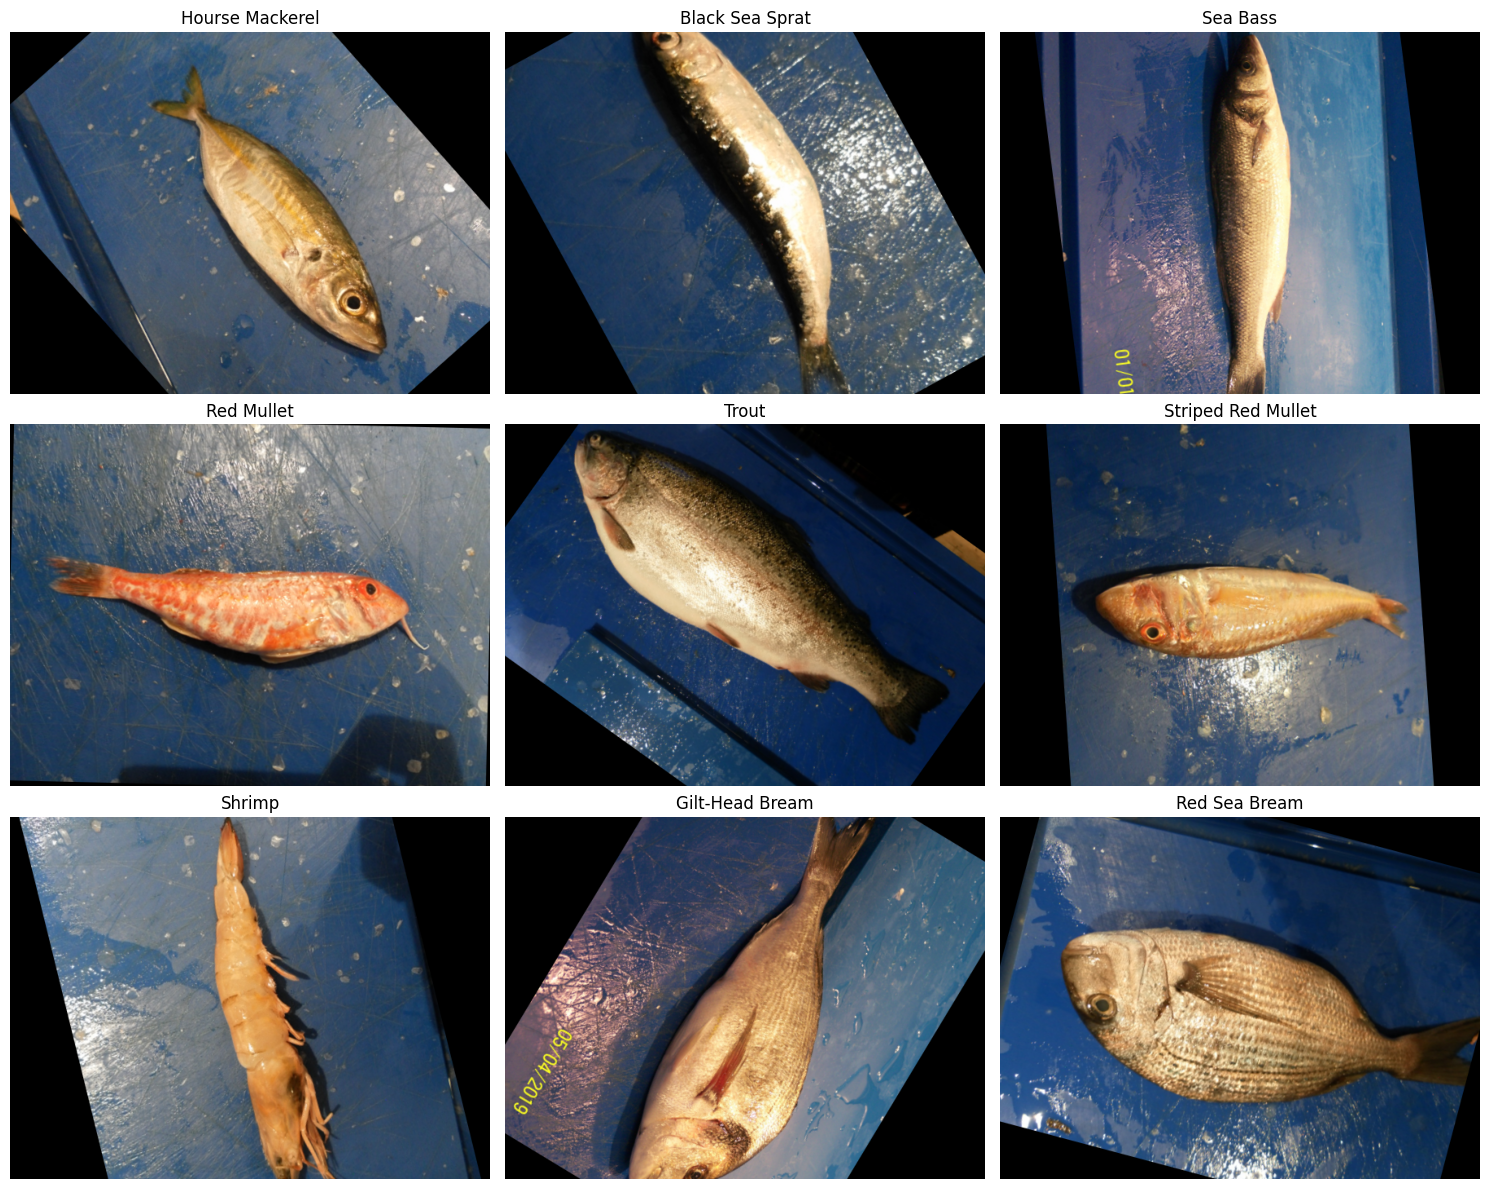

In [7]:
unique_labels = data_frame['label'].unique()

plt.figure(figsize=(15,12))

for idx, unique_label in enumerate(unique_labels):
    plt.subplot(3, 3, idx+1)
    
    image_path = data_frame[data_frame['label'] == unique_label].iloc[0, 0]
    
    image = plt.imread(image_path)
    
    plt.imshow(image)
    
    plt.title(unique_label)
    
    plt.axis('off')

plt.tight_layout()

plt.show()


These are example images of the fish types in the dataset

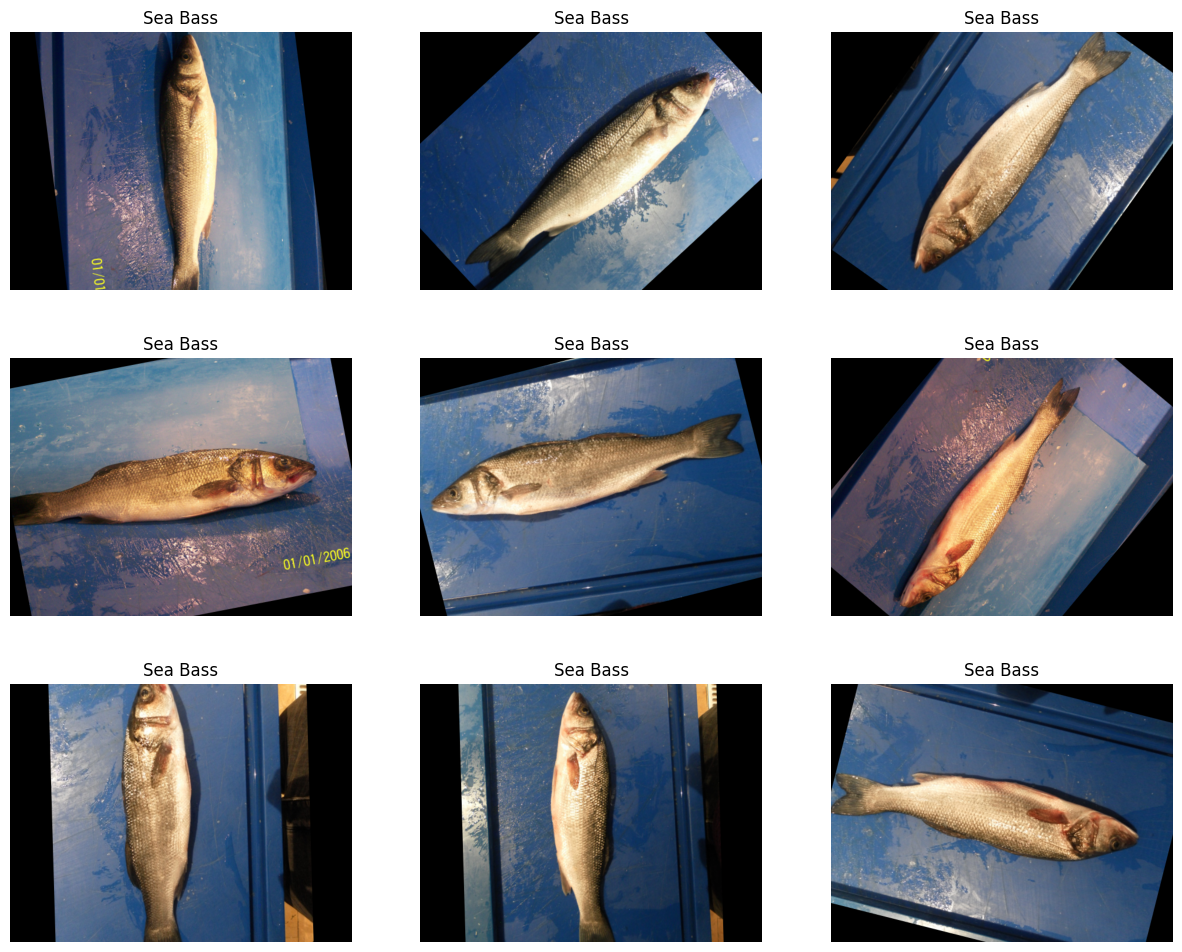

In [8]:
idx = 0

plt.figure(figsize=(15, 12))

for unique_label in data_frame['label'].unique():
    plt.subplot(3, 3, idx + 1)
    
    plt.imshow(plt.imread(data_frame[data_frame['label'] == "Sea Bass"].iloc[idx, 0]))
    
    plt.title("Sea Bass")
    
    plt.axis('off')
    
    idx += 1

plt.show()


More example images of the fish type 'Sea Bass' are displayed, showing the variety of images in the dataset.

In [9]:
main_directory = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

images = []
labels = []

for directory in tqdm(os.listdir(main_directory)):
    next_directory = os.path.join(main_directory, directory)

    if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
    
    i = 0
    for images_directory in os.listdir(next_directory):
        if "GT" not in images_directory:
            final_directory = os.path.join(next_directory, images_directory)
            for image in os.listdir(final_directory):
                image_path = os.path.join(final_directory, image)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (224, 224)).astype('float32') / 255
                images.append(img_resized)
                labels.append(images_directory)
        i += 1


100%|██████████| 12/12 [02:24<00:00, 12.00s/it]


Changing the images to be used for training and testing

In [10]:
print(images[0]) 


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


Example of the converted image that will be used for training and testing

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, random_state=0, test_size=0.2)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=0, test_size=0.5)

This code splits the dataset into training, validation, and test sets, allocating 80% of the images for training and dividing the remaining 20% equally between validation and testing.


In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.2,    
    height_shift_range=0.2,  
    horizontal_flip=True,   
)

datagen.fit(X_train)

This is the configuration for the`ImageDataGenerator` class, which generates batches of tensor image data with real-time data augmentation.

In [13]:
print(type(X_train))
print(X_train[0].shape)
print(X_val[0].shape)
print(X_test[0].shape)
len(X_train)

<class 'list'>
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


7200

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)      
y_val = np.array(y_val)      

X_test = np.array(X_test)
y_test = np.array(y_test)

Convert the data to a format that can be used for training and testing

In [15]:
print(y_train)

['Shrimp' 'Sea Bass' 'Striped Red Mullet' ... 'Trout' 'Red Mullet'
 'Sea Bass']


This code prints the array of training labels, displaying the corresponding class labels for each image in the training set, which is useful for verifying the label distribution and correctness.


In [16]:
ncoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))

y_val = encoder.transform(y_val.reshape(-1, 1))

y_test = encoder.transform(y_test.reshape(-1, 1))

This code initializes a `OneHotEncoder` to convert the training, validation, and test labels into one-hot encoded format, enabling multi-class classification by representing each label as a binary vector.


In [17]:
print(y_train)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:

model = tf.keras.models.Sequential([
   tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    
   tf.keras.layers.Dense(256, activation='relu'),
    
    # keras.layers.Dropout(0.2),
    
    # Hidas.layers.Dense(128, activation='relu'),
    
    # Dropoulayers.Dropout(0.2),
    
    # Output laers.Dense(9, activation="softmax")  # The softmax acti

This code contains the secret souce of the model

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compile the model for training

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

results = model.fit(
    X_train, y_train,   
    batch_size=256,
    epochs=40,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/40


I0000 00:00:1729537135.559792    1650 service.cc:145] XLA service 0x7bb6c00054b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729537135.559993    1650 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729537135.560001    1650 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.1148 - loss: 3.8390

I0000 00:00:1729537139.803001    1650 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.1375 - loss: 4.1580 - val_accuracy: 0.3256 - val_loss: 1.9811
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.2514 - loss: 1.9919 - val_accuracy: 0.4356 - val_loss: 1.7229
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3336 - loss: 1.8182 - val_accuracy: 0.5278 - val_loss: 1.6016
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3843 - loss: 1.7049 - val_accuracy: 0.5656 - val_loss: 1.4709
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4109 - loss: 1.6335 - val_accuracy: 0.5878 - val_loss: 1.3625
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4448 - loss: 1.5406 - val_accuracy: 0.6589 - val_loss: 1.2671
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4766 - loss: 1.4704 - val_accuracy: 0.6700 - val_loss: 1.2133
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4931 - loss: 1.4291 - val_accuracy: 0.7089 - val_loss: 

Setup the early stopping callback to prevent overfitting and save the best model weights based on validation accuracy.

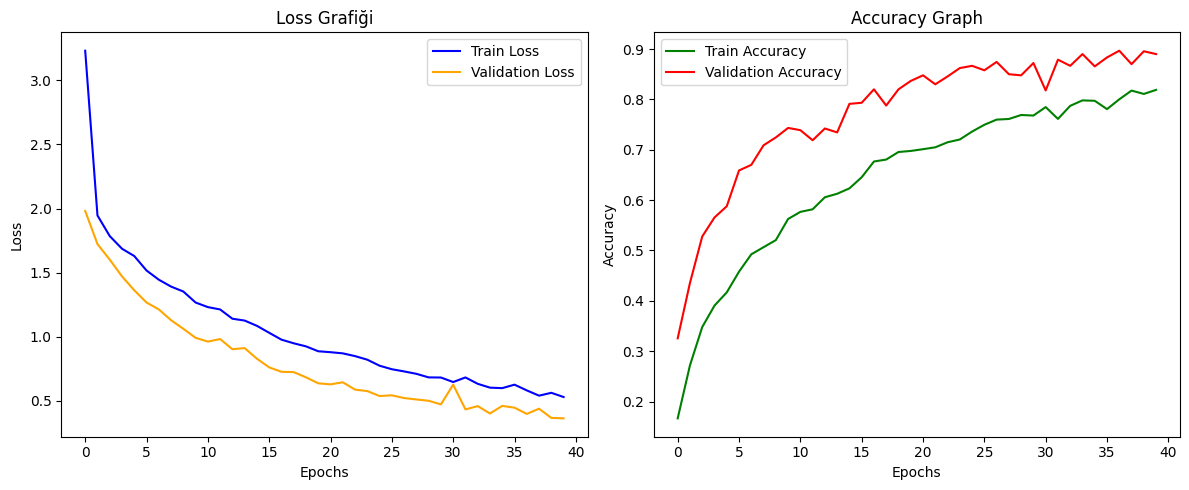

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Loss graph
axes[0].plot(results.history['loss'], label='Train Loss', color='blue') 
axes[0].plot(results.history['val_loss'], label='Validation Loss', color='orange')
axes[0].set_title('Loss Graph')
axes[0].set_xlabel('Epochs')  
axes[0].set_ylabel('Loss')  
axes[0].legend()

# Accuracy graph
axes[1].plot(results.history['accuracy'], label='Train Accuracy', color='green')
axes[1].plot(results.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1].set_title('Accuracy Graph')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()  


fig.tight_layout()
plt.show()


Graph of the model's performance during training

In [22]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Make predictions on the test set to evaluate the model's performance even further.

In [23]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

Test Accuracy: 0.8922222256660461
Test Loss: 0.36496245861053467


Results of the model evaluation on the test set

In [24]:
test_labels = encoder.inverse_transform(y_test)

prediction_labels = encoder.inverse_transform(y_pred_classes.reshape(-1, 1))

This code converts the one-hot encoded test labels and predicted labels back to their original class labels, enabling further analysis such as generating confusion matrices or classification reports for performance evaluation.


In [25]:
pprint(classification_report(test_labels, prediction_labels))


                    precision    recall  f1-score   support

   Black Sea Sprat       0.88      0.98      0.93       101
   Gilt-Head Bream       0.94      0.87      0.91        94
   Hourse Mackerel       0.78      0.99      0.87        98
        Red Mullet       0.93      0.99      0.96       101
     Red Sea Bream       0.93      0.87      0.90       104
          Sea Bass       0.90      0.81      0.85        89
            Shrimp       0.91      0.91      0.91       100
Striped Red Mullet       0.92      0.81      0.86       106
             Trout       0.87      0.80      0.83       107

          accuracy                           0.89       900
         macro avg       0.90      0.89      0.89       900
      weighted avg       0.90      0.89      0.89       900



This code prints a classification report that evaluates the model's performance, detailing precision, recall, and F1-score for each class, along with overall accuracy and support, which helps in understanding the model's effectiveness and areas for improvement.
